### Extracting Features from Relational Data with Featuretools


In previous chapters, we worked with data organized in rows and columns, where the columns are the variables, the rows are the observations, and each observation is independent. In this chapter, we will focus on creating features from relational datasets. In relational datasets, data is structured across various tables, which can be joined together via unique identifiers. These unique identifiers indicate relationships that exist between the different tables

A classic example of relational data is that held by retail companies. One table contains information about customers, such as names and addresses. A second table has information about the purchases made by the customers, such as the type and number of items bought per purchase. A third table contains information about the customers' interactions with the company's website, variables such as session duration, the mobile device used, and pages visited. Customers, purchases, and sessions are identified with unique identifiers. These unique identifiers allow us to put these tables together, and in this way, we can get information about customers' purchases or sessions.

In this chapter, we will cover the following recipes:
			
- Setting up an entity set and creating features automatically
- Creating features with general and cumulative operations
- Combining numerical features
- Extracting features from date and time

### Setting up an entity set and creating features automatically

Relational datasets or databases contain data spread across multiple tables, and the relationships between tables are dictated by a unique identifier that tells us how we can join those tables

![Working with relation tables](../img/relations.png)

Each customer made one or more purchases, identified by the invoice number. Each invoice contains one or more items, identified by the stock code. Each item can be bought by one or more customers and is therefore present in several invoices. With these relationships in mind, lets proceed to the recipe

In [30]:
import warnings
import pandas as pd
import featuretools as ft
from woodwork.logical_types import Categorical

warnings.filterwarnings('ignore')

In [31]:
df = pd.read_csv('../source/ch09-featuretools/retail.csv', parse_dates=['invoice_date'])

df.head()

,customer_id,invoice,invoice_date,stock_code,description,quantity,price
0,13085.0,489434,2009-12-01 07:45:00,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95
1,13085.0,489434,2009-12-01 07:45:00,79323P,PINK CHERRY LIGHTS,12,6.75
2,13085.0,489434,2009-12-01 07:45:00,79323W,WHITE CHERRY LIGHTS,12,6.75
3,13085.0,489434,2009-12-01 07:45:00,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10
4,13085.0,489434,2009-12-01 07:45:00,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25


**NOTE**: Use pandas' unique() function to identify the number of unique items, customers, and invoices - for example, by executing df["customer_id"].nunique().

Let's initialize an entity set with an arbitrary name, such as data:

In [32]:
es = ft.EntitySet(id='data')

Let's add a DataFrame to the entity set; we give the DataFrame a name (data). We need to add a unique identifier for each row, which we call rows, and since we do not have a unique row identifier in this dataset, we will create it as an additional column by setting make_index=True. Finally, we indicate that invoice_date is of the datetime type and customer_id should be handled as Categorical

In [33]:
es = es.add_dataframe(
    dataframe=df,
    dataframe_name="data",
    index="rows",
    make_index=True,
    time_index="invoice_date",
    logical_types={"customer_id": Categorical}
)

Next, we add the relationship between the original data DataFrame and invoices. To do this, we indicate the original or base DataFrame, which we called data in step 4, we give the new DataFrame a name, invoices, we add the unique identifier for invoices, and we add the column containing customer_id to this DataFrame

In [34]:
es.normalize_dataframe(
    base_dataframe_name="data",
    new_dataframe_name="invoices",
    index="invoice",
    copy_columns=["customer_id"]
)

Entityset: data
  DataFrames:
    data [Rows: 741301, Columns: 8]
    invoices [Rows: 40505, Columns: 3]
  Relationships:
    data.invoice -> invoices.invoice

In [35]:
es.normalize_dataframe(
    base_dataframe_name="invoices",  # note that we use the df from the previous cell
    new_dataframe_name="customers",  # the name of the new df
    index="customer_id",             # the column that indicates the relationship
)

Entityset: data
  DataFrames:
    data [Rows: 741301, Columns: 8]
    invoices [Rows: 40505, Columns: 3]
    customers [Rows: 5410, Columns: 2]
  Relationships:
    data.invoice -> invoices.invoice
    invoices.customer_id -> customers.customer_id

We can add a third relationship between the original data and the products

In [36]:
es.normalize_dataframe(
    base_dataframe_name="data",
    new_dataframe_name="items",
    index="stock_code"
)

Entityset: data
  DataFrames:
    data [Rows: 741301, Columns: 8]
    invoices [Rows: 40505, Columns: 3]
    customers [Rows: 5410, Columns: 2]
    items [Rows: 4631, Columns: 2]
  Relationships:
    data.invoice -> invoices.invoice
    invoices.customer_id -> customers.customer_id
    data.stock_code -> items.stock_code

In [37]:
es['invoices'].head()

,invoice,customer_id,first_data_time
489434,489434,13085.0,2009-12-01 07:45:00
489435,489435,13085.0,2009-12-01 07:46:00
489436,489436,13078.0,2009-12-01 09:06:00
489437,489437,15362.0,2009-12-01 09:08:00
489438,489438,18102.0,2009-12-01 09:24:00


In [38]:
es["customers"].head()

,customer_id,first_invoices_time
13085.0,13085.0,2009-12-01 07:45:00
13078.0,13078.0,2009-12-01 09:06:00
15362.0,15362.0,2009-12-01 09:08:00
18102.0,18102.0,2009-12-01 09:24:00
18087.0,18087.0,2009-12-01 09:43:00


We can see in the following output that featuretools automatically created a DataFrame containing the customer's unique identifier, followed by the date of the first invoice for this customer:

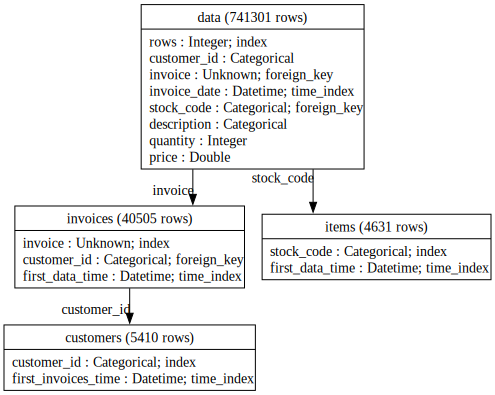

In [40]:
es.plot()

Let's create features by aggregating the data at the customer level. To do this, we set up the deep feature synthesis (dfs) class from featuretools, indicating customers as the target DataFrame. When creating features, we want to ignore the two columns with unique identifiers:

In [44]:
# Now we can start aggregating the data for each level.

# Let's begin with customers

feature_matrix, feature_defs = ft.dfs(
    entityset=es,                        # the entity set
    target_dataframe_name="customers",   # the dataframe for wich to create the features
    ignore_columns={                     # columns to ignore when creating features
        "invoices":["invoice"],
        "data":["customer_id"],
    }
)

print(len(feature_defs))

# display name of created features
feature_defs[5:10]

114


[<Feature: MIN(data.price)>,
 <Feature: MIN(data.quantity)>,
 <Feature: MODE(data.description)>,
 <Feature: MODE(data.stock_code)>,
 <Feature: NUM_UNIQUE(data.description)>]

Lets display the first five rows of the DataFrame containing five of the created features:

In [49]:
feature_matrix[feature_matrix.columns[5:10]].head()

,MIN(data.price),MIN(data.quantity),MODE(data.description),MODE(data.stock_code),NUM_UNIQUE(data.description)
customer_id,,,,,
13085.0,0.55,-48.0,"RECORD FRAME 7"" SINGLE SIZE",22041,52
13078.0,0.19,-14.0,AREA PATROLLED METAL SIGN,82582,165
15362.0,0.21,1.0,BLUE PADDED SOFT MOBILE,20703,38
18102.0,0.27,-324.0,CREAM HEART CARD HOLDER,22189,415
18087.0,0.36,-96.0,WHITE HANGING HEART T-LIGHT HOLDER,85123A,48


Similarly, we can create features automatically by aggregating information at the invoice level:

In [50]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="invoices",
    ignore_columns={"data": ["customer_id"]},
    max_depth=1,
)

In [51]:
feature_defs

[<Feature: customer_id>,
 <Feature: COUNT(data)>,
 <Feature: MAX(data.price)>,
 <Feature: MAX(data.quantity)>,
 <Feature: MEAN(data.price)>,
 <Feature: MEAN(data.quantity)>,
 <Feature: MIN(data.price)>,
 <Feature: MIN(data.quantity)>,
 <Feature: MODE(data.description)>,
 <Feature: MODE(data.stock_code)>,
 <Feature: NUM_UNIQUE(data.description)>,
 <Feature: NUM_UNIQUE(data.stock_code)>,
 <Feature: SKEW(data.price)>,
 <Feature: SKEW(data.quantity)>,
 <Feature: STD(data.price)>,
 <Feature: STD(data.quantity)>,
 <Feature: SUM(data.price)>,
 <Feature: SUM(data.quantity)>,
 <Feature: DAY(first_data_time)>,
 <Feature: MONTH(first_data_time)>,
 <Feature: WEEKDAY(first_data_time)>,
 <Feature: YEAR(first_data_time)>]

In [52]:
feature_matrix.head()

,customer_id,COUNT(data),MAX(data.price),MAX(data.quantity),MEAN(data.price),MEAN(data.quantity),MIN(data.price),MIN(data.quantity),MODE(data.description),MODE(data.stock_code),NUM_UNIQUE(data.description),NUM_UNIQUE(data.stock_code),SKEW(data.price),SKEW(data.quantity),STD(data.price),STD(data.quantity),SUM(data.price),SUM(data.quantity),DAY(first_data_time),MONTH(first_data_time),WEEKDAY(first_data_time),YEAR(first_data_time)
invoice,,,,,,,,,,,,,,,,,,,,,,
489434,13085.0,8,6.95,48.0,4.081250,20.750000,1.25,10.0,WHITE CHERRY LIGHTS,21232,8,8,0.005779,1.609110,2.721205,12.646287,32.65,166.0,1,12,1,2009
489435,13085.0,4,3.75,24.0,2.625000,15.000000,1.65,12.0,CAT BOWL,22195,4,4,0.516958,2.000000,0.861684,6.000000,10.50,60.0,1,12,1,2009
489436,13078.0,19,8.50,24.0,3.730526,10.157895,1.25,2.0,PEACE WOODEN BLOCK LETTERS,21181,19,19,0.585934,0.484434,2.215269,5.899747,70.88,193.0,1,12,1,2009
489437,15362.0,23,9.95,12.0,3.628261,6.304348,0.65,1.0,BLUE PADDED SOFT MOBILE,10002,23,23,0.891079,0.465628,2.697424,4.149861,83.45,145.0,1,12,1,2009
489438,18102.0,17,6.40,60.0,2.591176,48.588235,0.98,28.0,CARROT CHARLIE+LOLA COASTER SET,20711,17,17,1.912915,-0.645841,1.540588,14.013649,44.05,826.0,1,12,1,2009


### Extracting features from date and time

In [69]:
import pandas as pd
import featuretools as ft
from featuretools.primitives import (
    IsFederalHoliday, DistanceToHoliday
)
from woodwork.logical_types import Categorical, NaturalLanguage

In [70]:
df = pd.read_csv('../source/ch09-featuretools/retail.csv', parse_dates=['invoice_date'])

df.head()

,customer_id,invoice,invoice_date,stock_code,description,quantity,price
0,13085.0,489434,2009-12-01 07:45:00,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95
1,13085.0,489434,2009-12-01 07:45:00,79323P,PINK CHERRY LIGHTS,12,6.75
2,13085.0,489434,2009-12-01 07:45:00,79323W,WHITE CHERRY LIGHTS,12,6.75
3,13085.0,489434,2009-12-01 07:45:00,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10
4,13085.0,489434,2009-12-01 07:45:00,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25


In [71]:
es = ft.EntitySet(id="data")

In [72]:
es = es.add_dataframe(
    dataframe=df,
    dataframe_name="data",
    index="rows",
    make_index=True,
    time_index="invoice_date",
    logical_types={"customer_id": Categorical}
)

In [73]:
es.normalize_dataframe(
    base_dataframe_name="data",
    new_dataframe_name="invoices",
    index="invoice",
    copy_columns=["customer_id"]
)

Entityset: data
  DataFrames:
    data [Rows: 741301, Columns: 8]
    invoices [Rows: 40505, Columns: 3]
  Relationships:
    data.invoice -> invoices.invoice

In [74]:
is_bank_hol = IsFederalHoliday(country="AO")

Let's check out which bank holidays are included in this primitive

In [75]:
hols = is_bank_hol.holidayUtil.federal_holidays.values()
available_hols = list(set(hols))
available_hols

['Day off for Africa Day',
 'Carnival Day',
 "Day off for National Heroes' Day",
 'Southern Africa Liberation Day',
 'Martyrs of Colonial Repression Day',
 'Peace and National Reconciliation Day',
 'Day off for Christmas and Family Day',
 'Independence Day',
 'Day off for National Independence Day',
 "Day off for Carnival Day; International Women's Day",
 "Day off for All Souls' Day",
 'Day off for Southern Africa Liberation Day',
 'Day off for Southern Africa Liberation Day; Good Friday',
 'Family Day',
 "National Heroes' Day",
 'Date of Founding of MPLA - Labor Party',
 'Day off for Peace and National Reconciliation Day',
 'Christmas and Family Day',
 'Liberation Movement Day',
 'Day off for Carnival Day',
 "Day off for International Children's Day",
 "All Souls' Day",
 "Day off for International Women's Day",
 "Day off for International Worker's Day",
 'National Independence Day',
 'General Election Day',
 'Day off for Liberation Movement Day',
 "International Children's Day",
 'Goo

In [76]:
good_friday = DistanceToHoliday(holiday='Good Friday', country='AO')


Now, let's make a list containing strings that identify common features that we can get from datetime and include the primitives from steps 6 and 8:

In [77]:
date_primitives = [
    "day","year","month","weekday",
    "days_in_month","part_of_day",
    "hour","minute",
    is_bank_hol,
    good_friday
]

Let's now create date and time features from step 9 based on the invoice_date date variable:

In [78]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="invoices",
    agg_primitives=[],
    trans_primitives=date_primitives
)

In [79]:
feature_defs

[<Feature: customer_id>,
 <Feature: DAY(first_data_time)>,
 <Feature: DAYS_IN_MONTH(first_data_time)>,
 <Feature: DISTANCE_TO_HOLIDAY(first_data_time, holiday=Good Friday, country=AO)>,
 <Feature: HOUR(first_data_time)>,
 <Feature: IS_FEDERAL_HOLIDAY(first_data_time, country=AO)>,
 <Feature: MINUTE(first_data_time)>,
 <Feature: MONTH(first_data_time)>,
 <Feature: PART_OF_DAY(first_data_time)>,
 <Feature: WEEKDAY(first_data_time)>,
 <Feature: YEAR(first_data_time)>]

Let's display the resulting DataFrame containing three of the new features

In [80]:
columns = [
    "DISTANCE_TO_HOLIDAY(first_data_time, holiday=Good Friday, country=AO)",
    "HOUR(first_data_time)",
    "IS_FEDERAL_HOLIDAY(first_data_time, country=AO)"
]

feature_matrix[columns].head()

,"DISTANCE_TO_HOLIDAY(first_data_time, holiday=Good Friday, country=AO)",HOUR(first_data_time),"IS_FEDERAL_HOLIDAY(first_data_time, country=AO)"
invoice,,,
489434,122.0,7,False
489435,122.0,7,False
489436,122.0,9,False
489437,122.0,9,False
489438,122.0,9,False


### Extracting features from text

In [81]:
es = ft.EntitySet(id="data")

In [92]:
es = es.add_dataframe(
    dataframe=df,              # the dataframe with the data
    dataframe_name="data",     # unique name to associate with this dataframe
    index="rows",              # column name to index the items
    make_index=True,           # if true, create a new column with unique values
    time_index="invoice_date", # column containing time data
    logical_types={
        "customer_id": Categorical, # the id is numerical, but should be handled as categorical
        "invoice": Categorical,
        "description": NaturalLanguage, # we need to set this variable as text for ft to work
    },
)

In [93]:
# Create a new dataframe with invoices
# indicating its relationship to the main data

es.normalize_dataframe(
    base_dataframe_name="data",     # Datarame name from which to split.
    new_dataframe_name="invoices",  # Name of the new dataframe.
    index="invoice",                # relationship will be created across this column.
    copy_columns=["customer_id"],   # columns to remove from base_dataframe and move to new dataframe.
)

Entityset: data
  DataFrames:
    data [Rows: 741301, Columns: 8]
    invoices [Rows: 40505, Columns: 3]
  Relationships:
    data.invoice -> invoices.invoice

In [94]:
text_primitives = [
    "num_words",
    "num_characters",
    "MeanCharactersPerWord",
    "PunctuationCount"
]

Let's now extract the text features from the description variable

In [95]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,                       # the entity set
    target_dataframe_name="data",       # the dataframe for wich to create the feature
    agg_primitives=[],                  # we need an empty list to avoid returning the defo parameters
    trans_primitives=text_primitives,   # the date features to extract
    ignore_dataframes=["invoices"],
)

# display name of created features
feature_defs

[<Feature: customer_id>,
 <Feature: stock_code>,
 <Feature: description>,
 <Feature: quantity>,
 <Feature: price>]